# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* TimeSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* TwoStageSplitter

Each of them provides its own capabilities for data split.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached DataFrame to compute them once and re-use for models training, inference and metrics calculation.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from replay.preprocessing import LabelEncoder, LabelEncodingRule

sns.set_theme(style="whitegrid", palette="muted")

## Get started

Download the dataset **MovieLens** and preprocess it with `LabelEncoder`

In [2]:
ratings = pd.read_csv('./data/ml1m_ratings.dat',sep="\t",names=["user_id", "item_id", "rating", "timestamp"], engine='python')
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')

In [3]:
ratings.head(5)

,user_id,item_id,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [ ]:
encoder = LabelEncoder(
    [
        LabelEncodingRule("user_id"),
        LabelEncodingRule("item_id"),
    ]
)
ratings = encoder.fit_transform(ratings)

For examples, we will use the 20 users with biggest interactions history

In [5]:
top_users = (
    ratings.groupby("user_id")[["item_id"]].count()
    .nlargest(n=20, columns=["item_id"])
    .index
)

In [6]:
log_limit_20 = ratings[ratings.user_id.isin(top_users)]

In [7]:
len(log_limit_20)

28229

Function for viewing `train`, `test` data

In [8]:
def show_train_test(train, test):
    plt.figure(figsize=(25,12))
    train_plt = train
    train_plt["split"] = 'train'
    test_plt = test
    test_plt["split"] = 'test'
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    pd_for_print["user_id"] = pd_for_print["user_id"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_id", hue="split",s=8*8)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()

Function for printing stats of df

In [9]:
def get_df_info(df: pd.DataFrame):
    print(f"Total rows {len(df)}, unique users: {df.user_id.nunique()}, unique items: {df.item_id.nunique()}")

## General parameters of splitters

All splitters has the following common parameters:
* `drop_cold_users` flag to drop cold (not presented in train part) users from test

* `drop_cold_items` flag to drop cold (not presented in train part) users from test

* `date_column` timestamp column name

* `query_column` query id column name

* `item_column` item id column name

## class TimeSplitter()

Split into train and test by date.

#### Parameters other than gneral

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically


In this example `test_start` parameter will take fraction for test size

In [10]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.05,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [11]:
train, test = date_splitter.split(log_limit_20)

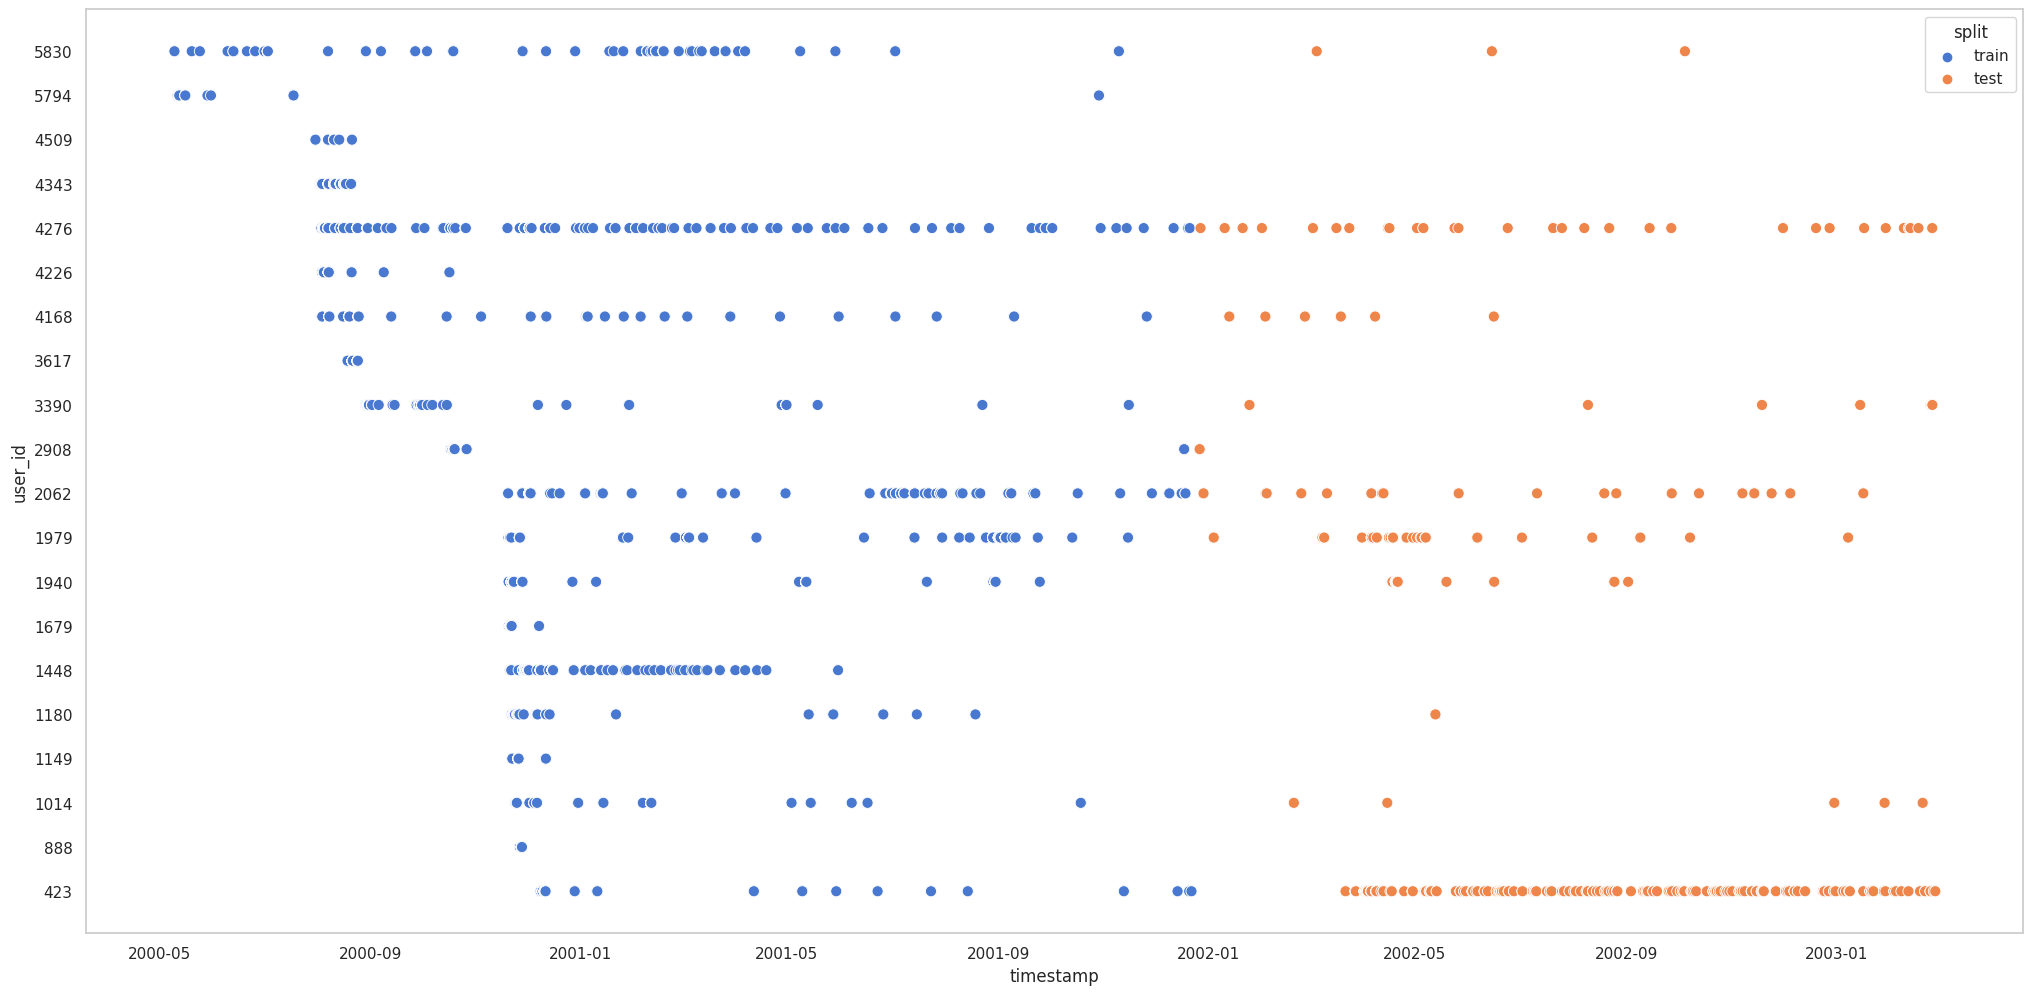

In [12]:
show_train_test(train, test)

In [13]:
get_df_info(train)

Total rows 26816, unique users: 20, unique items: 3303


In [14]:
get_df_info(test)

Total rows 1387, unique users: 11, unique items: 1152


In this example `test_start` parameter will take string "yyyy-mm-dd"

In [15]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold="2001-09",
    drop_cold_users=True,
    drop_cold_items=True,
    time_column_format="%Y-%m",
    query_column="user_id",
)

In [16]:
train, test = date_splitter.split(log_limit_20)

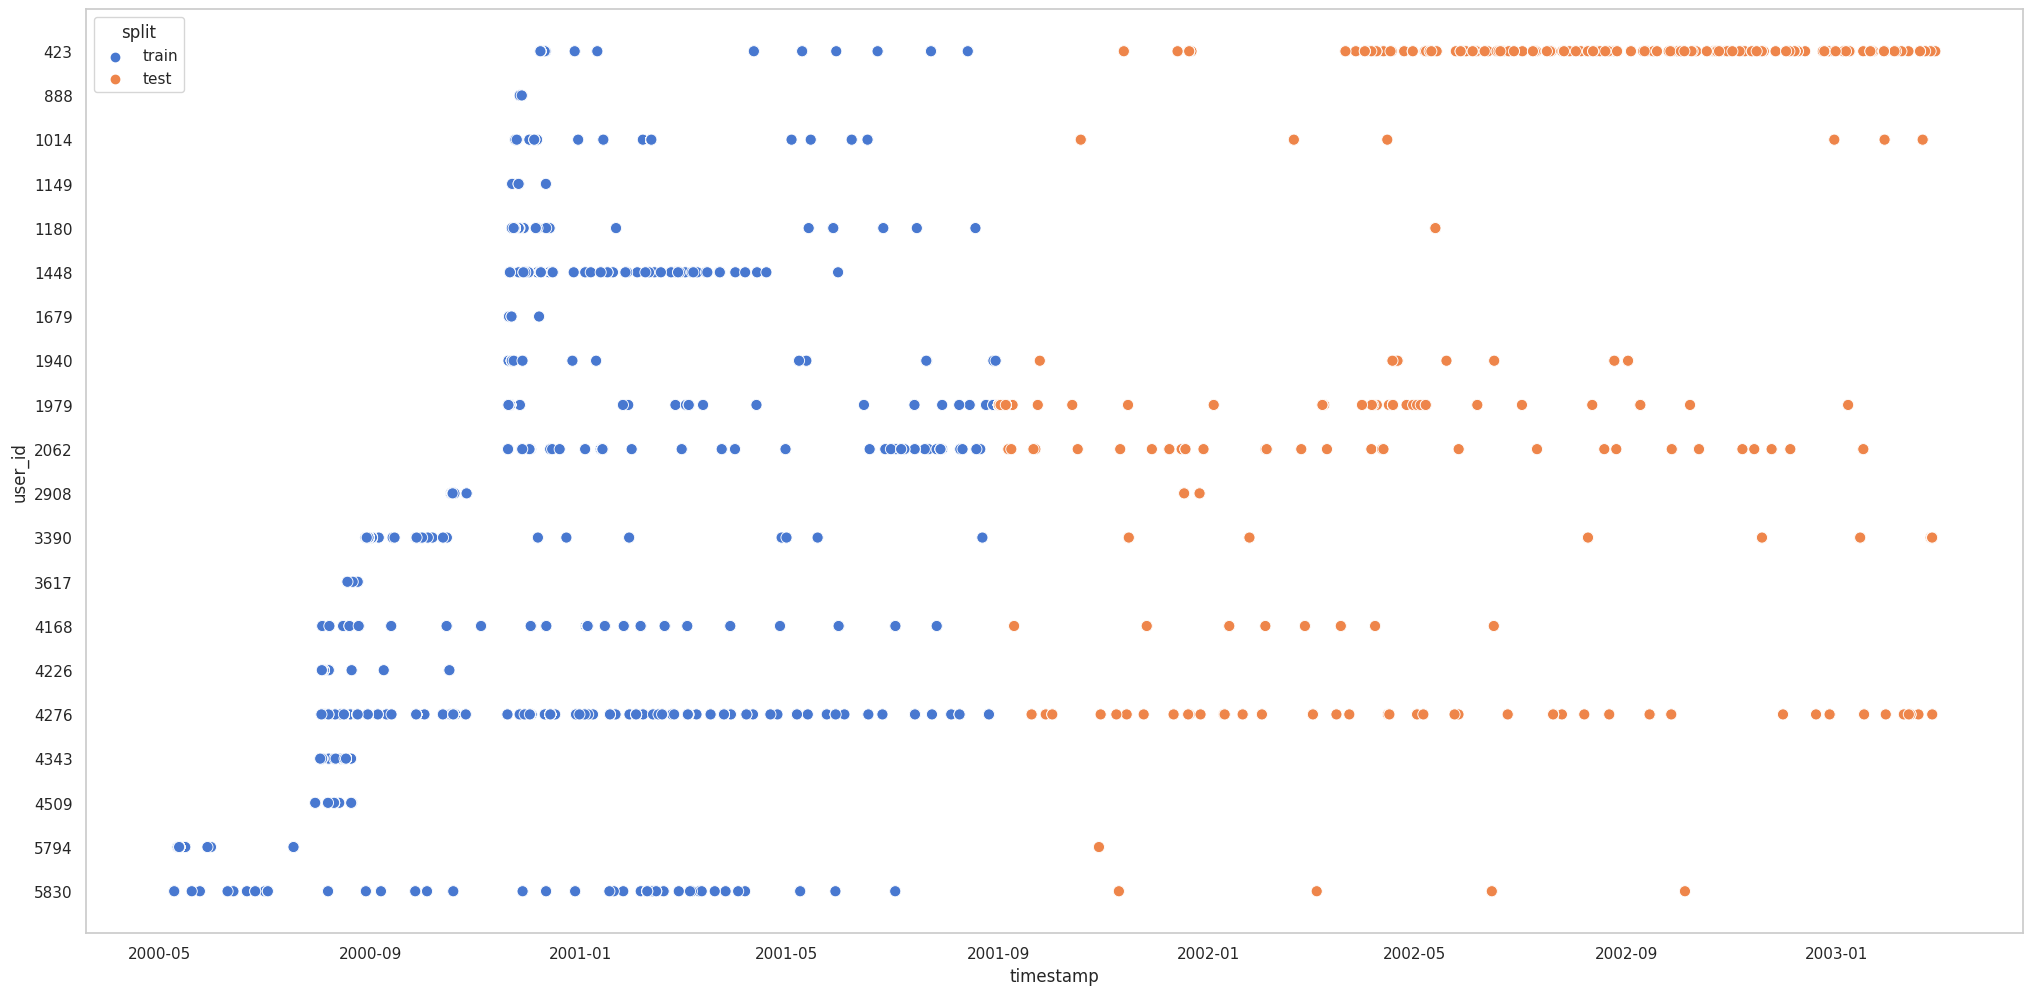

In [17]:
show_train_test(train, test)

In [18]:
get_df_info(train)

Total rows 26345, unique users: 20, unique items: 3281


In [19]:
get_df_info(test)

Total rows 1834, unique users: 12, unique items: 1399


### Learn more about the parameters `drop_cold_users`, `drop_cold_items`, `drop_zero_rel_in_test`

#### All parameters is false

In [20]:
from replay.splitters import TimeSplitter

date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()`

In [21]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 300065, unique users: 2283, unique items: 3572


#### `drop_cold_users` is True 

In [22]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=True,
    drop_cold_items=False,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_users=True`. Compared to the disabled flag, the number of users has decreased.

In [23]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 111169, unique users: 1113, unique items: 3459


#### `drop_cold_items` is True 

In [24]:
date_splitter = TimeSplitter(
    time_threshold=0.3,
    drop_cold_users=False,
    drop_cold_items=True,
    query_column="user_id",
)

Let's look at the result of filtering using the function  `get_log_info()` with `drop_cold_items=True`. Compared to the disabled flag, the number of items has decreased.

In [25]:
train, test = date_splitter.split(ratings)
get_df_info(test)

Total rows 299894, unique users: 2283, unique items: 3499


## class RandomSplitter()

Assign records into train and test at random.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [26]:
from replay.splitters import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column="user_id",
)

In [27]:
train, test = random_splitter.split(log_limit_20)

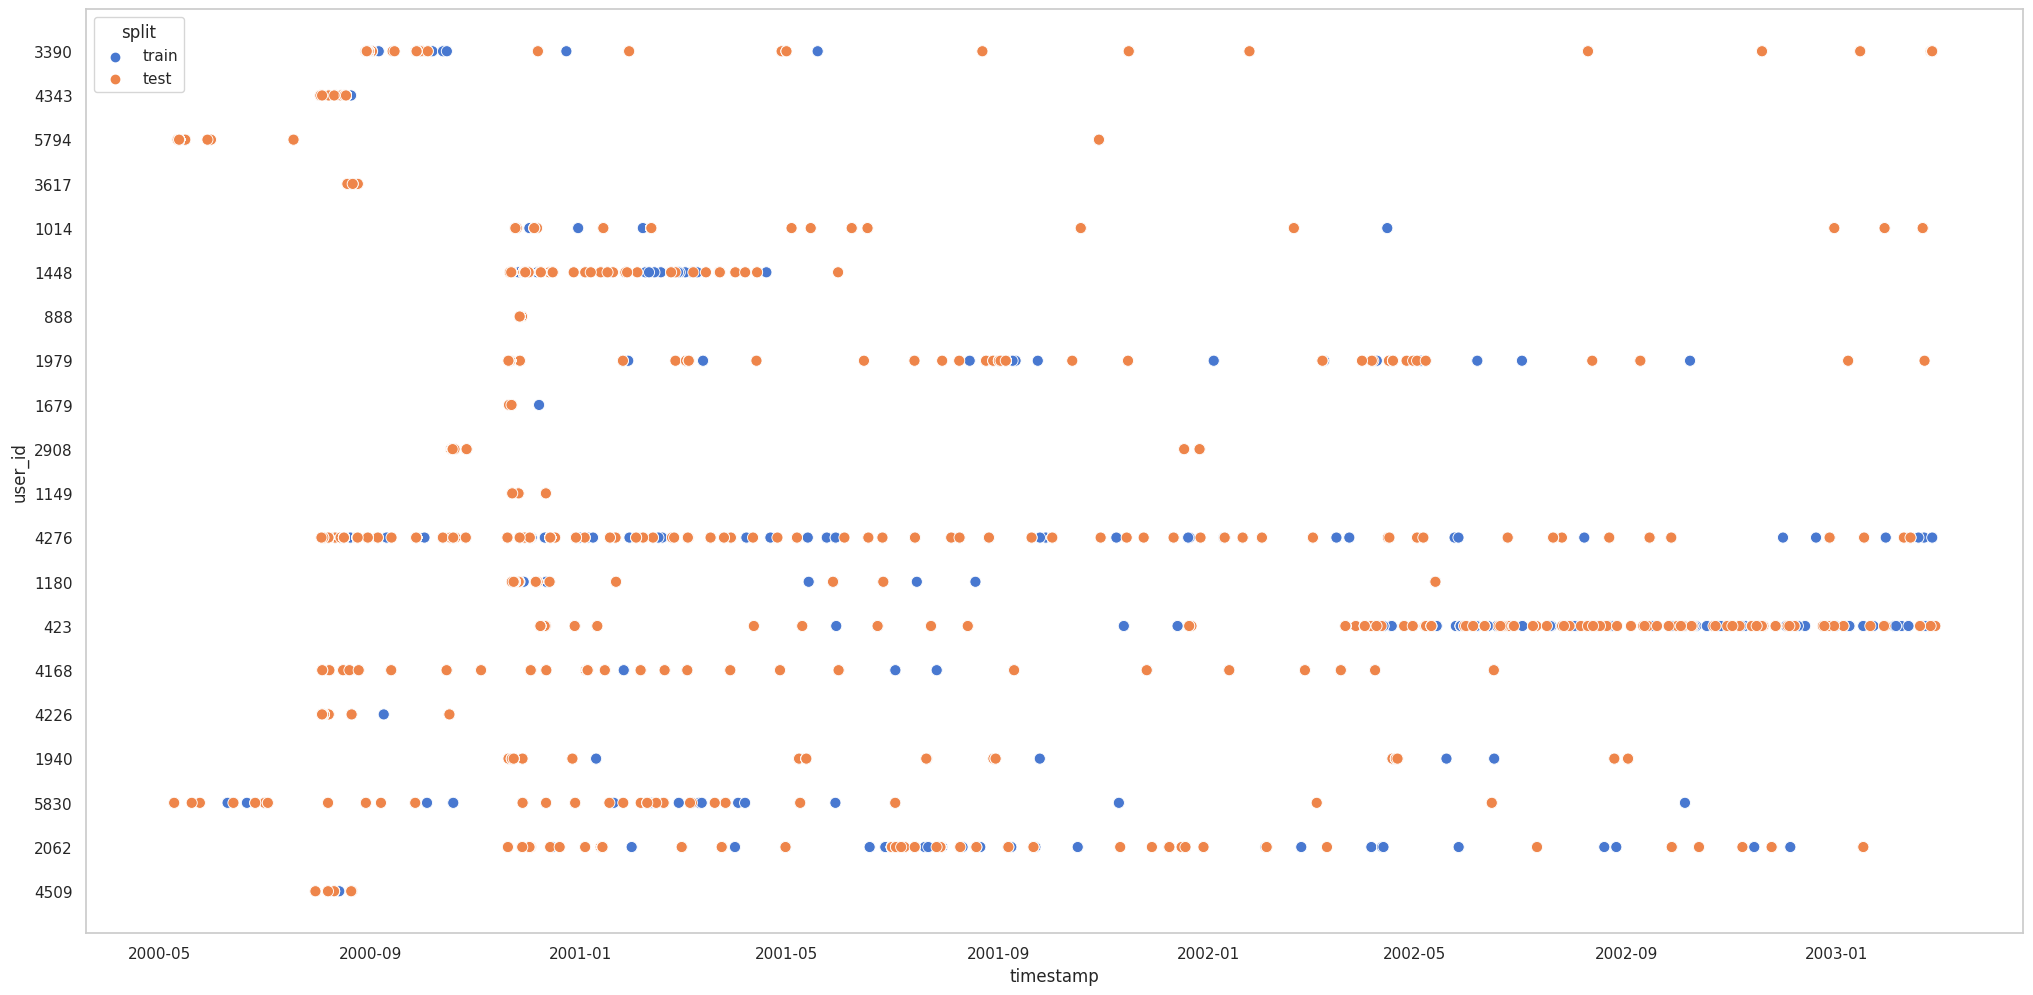

In [28]:
show_train_test(train, test)

In [29]:
get_df_info(train)

Total rows 16937, unique users: 20, unique items: 3147


In [30]:
get_df_info(test)

Total rows 11010, unique users: 20, unique items: 2759


## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters other than general

* `test_size` float 

In [31]:
from replay.splitters import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [32]:
train, test = new_user_splitter.split(log_limit_20)

/tmp/ipykernel_343596/2154144320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plt["split"] = 'train'


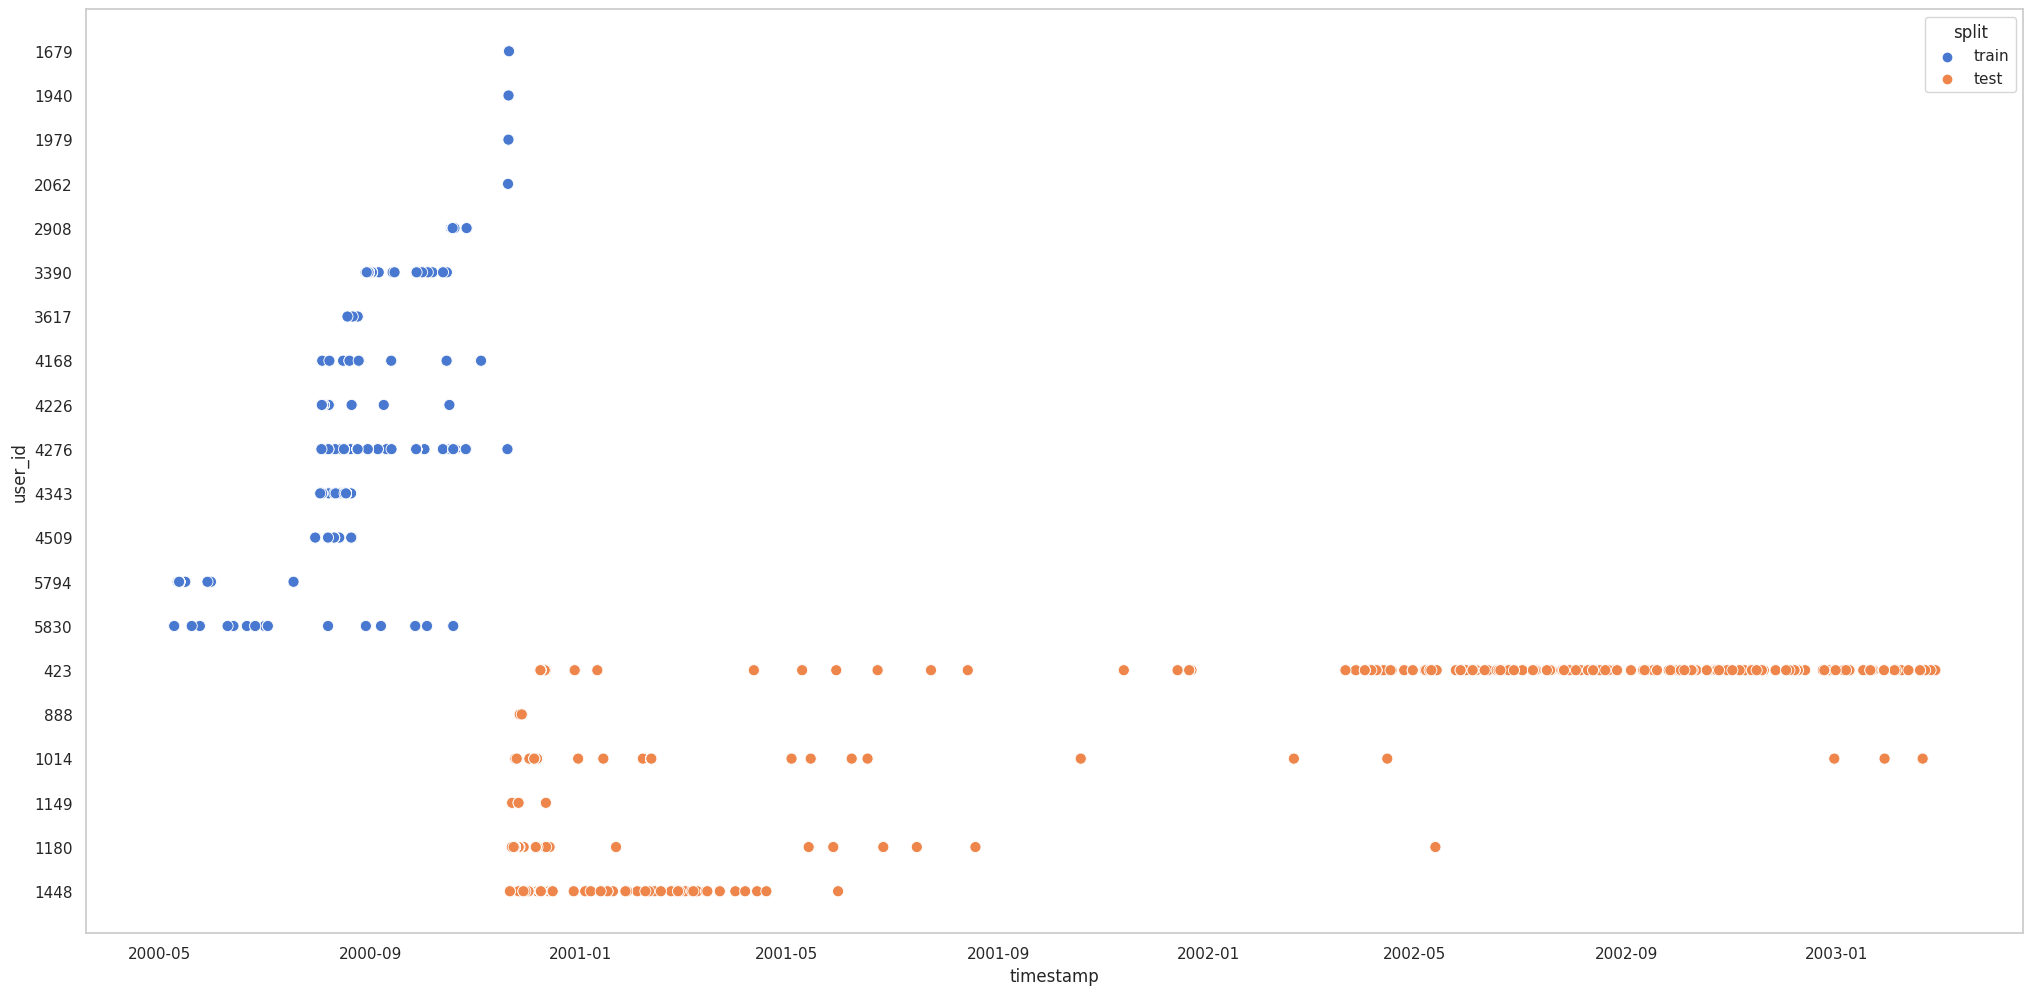

In [33]:
show_train_test(train, test)

In [34]:
get_df_info(train)

Total rows 13952, unique users: 14, unique items: 2931


In [35]:
get_df_info(test)

Total rows 8096, unique users: 6, unique items: 2757


## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters other than general

* `test_size` float 

* `seed` random seed

In [36]:
from replay.splitters import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3,
    query_column="user_id",
)

In [37]:
train, test = cold_user_random_splitter.split(log_limit_20)

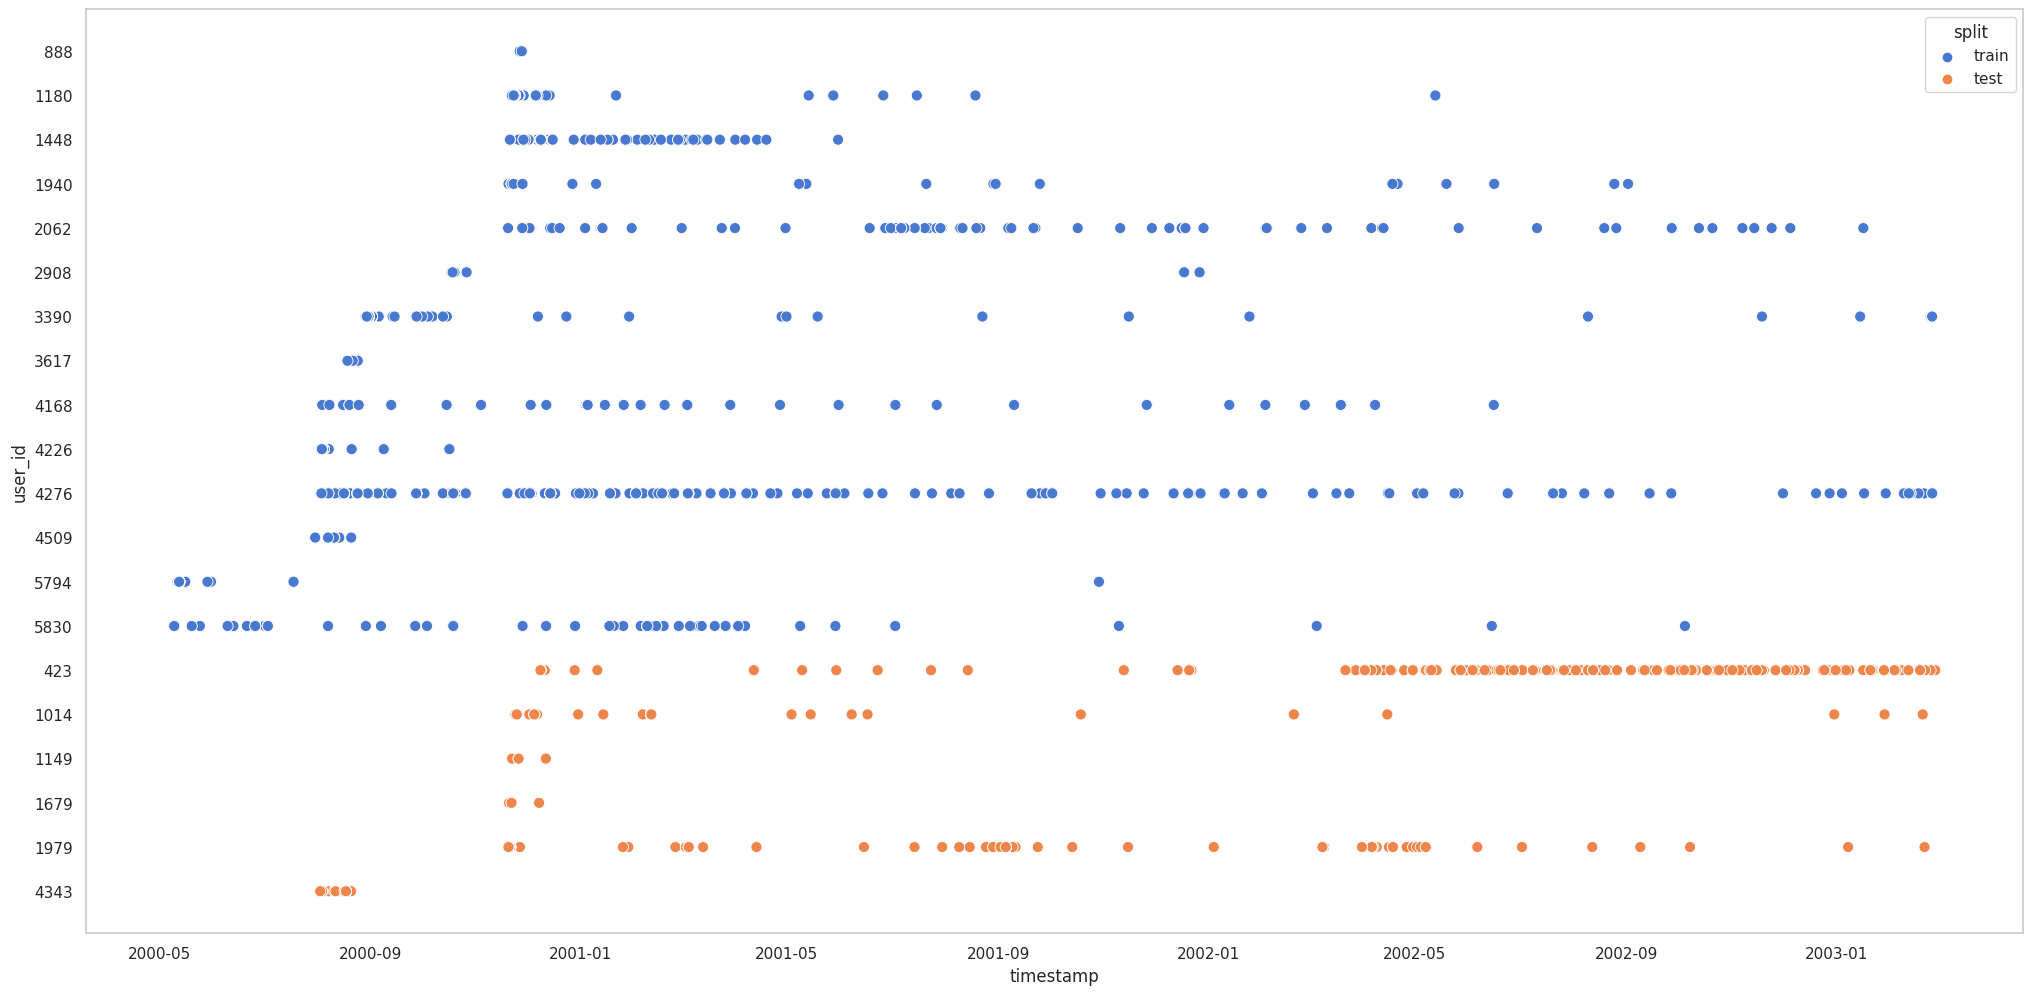

In [38]:
show_train_test(train, test)

In [39]:
get_df_info(train)

Total rows 20034, unique users: 14, unique items: 3258


In [40]:
get_df_info(test)

Total rows 8195, unique users: 6, unique items: 2706


## class TwoStageSplitter()

Split data by two columns.

#### Parameters other than general

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `seed` random seed

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [41]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=False,
    query_column="user_id",
    first_divide_column="user_id",
)

In [42]:
train, test = user_splitter.split(log_limit_20)

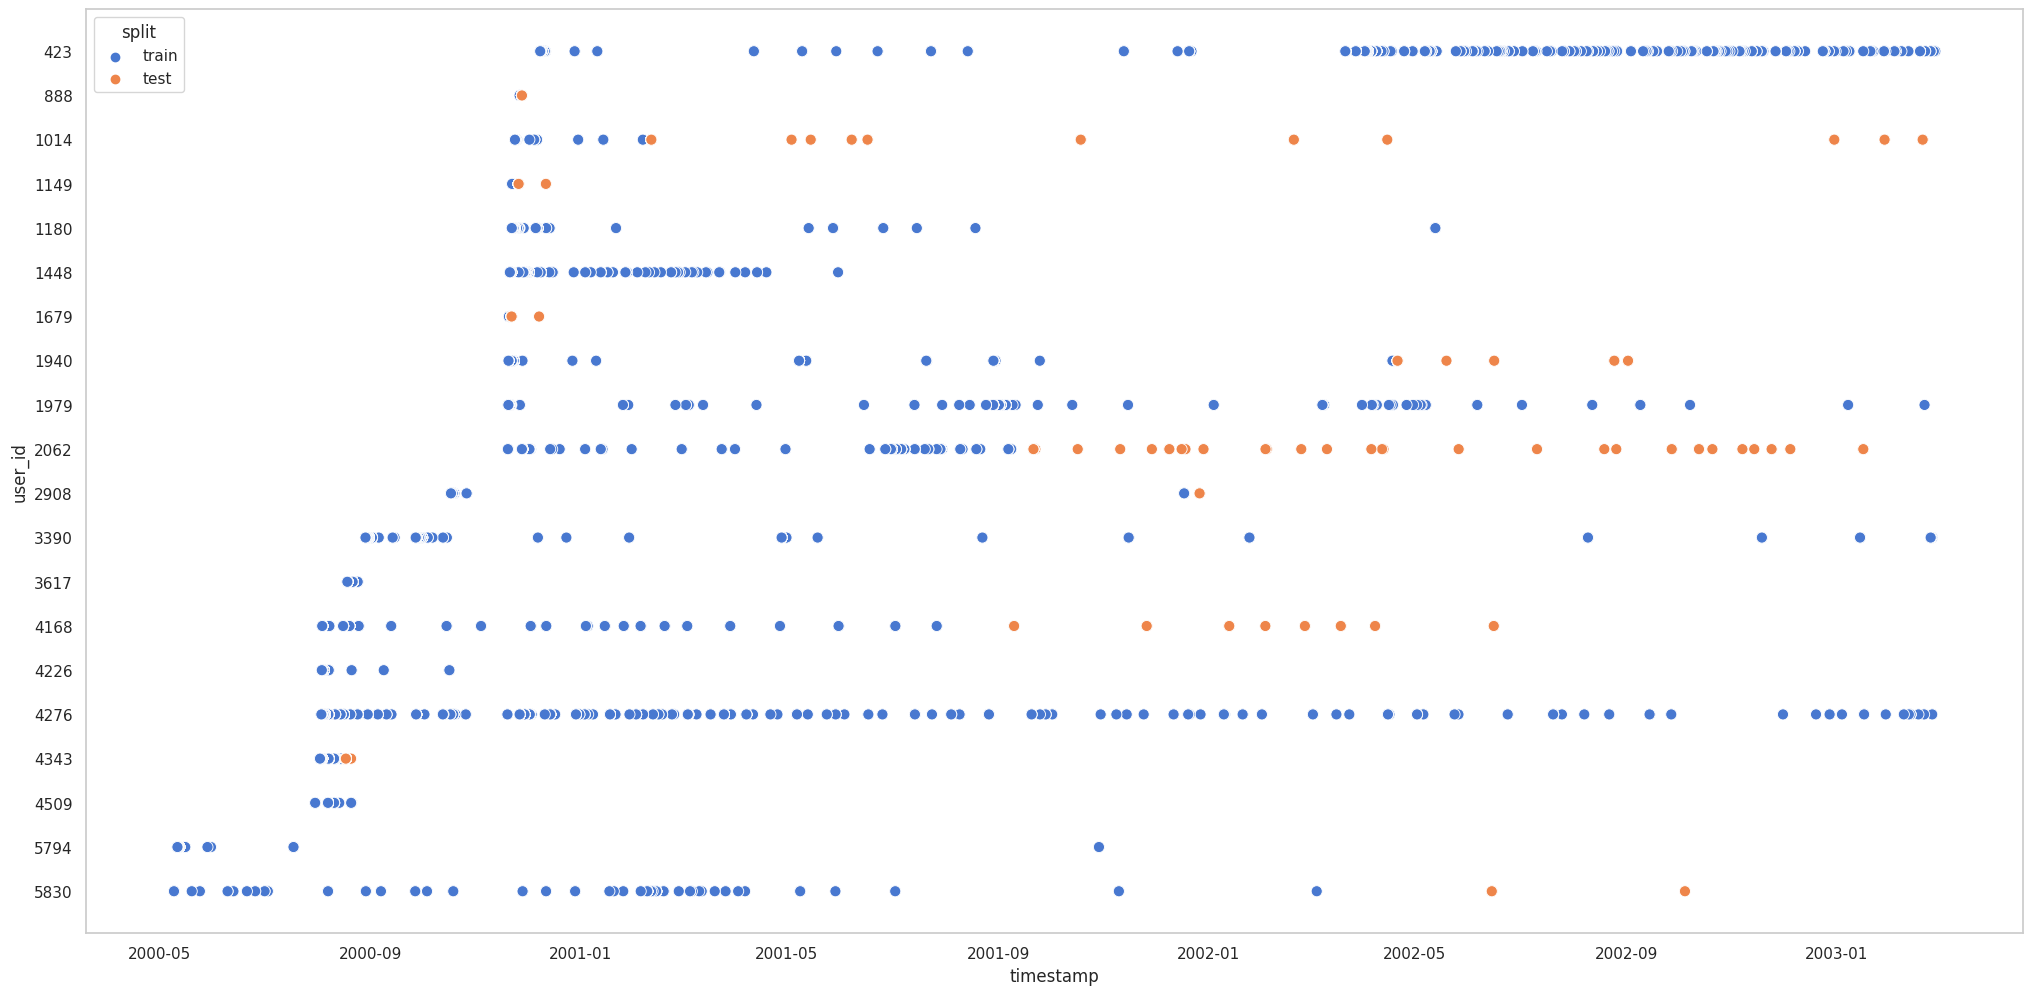

In [43]:
show_train_test(train, test)

In [44]:
get_df_info(train)

Total rows 27729, unique users: 20, unique items: 3301


In [45]:
get_df_info(test)

Total rows 500, unique users: 10, unique items: 461


In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [46]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=10,
    second_divide_size=50,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [47]:
train, test = user_splitter.split(log_limit_20)

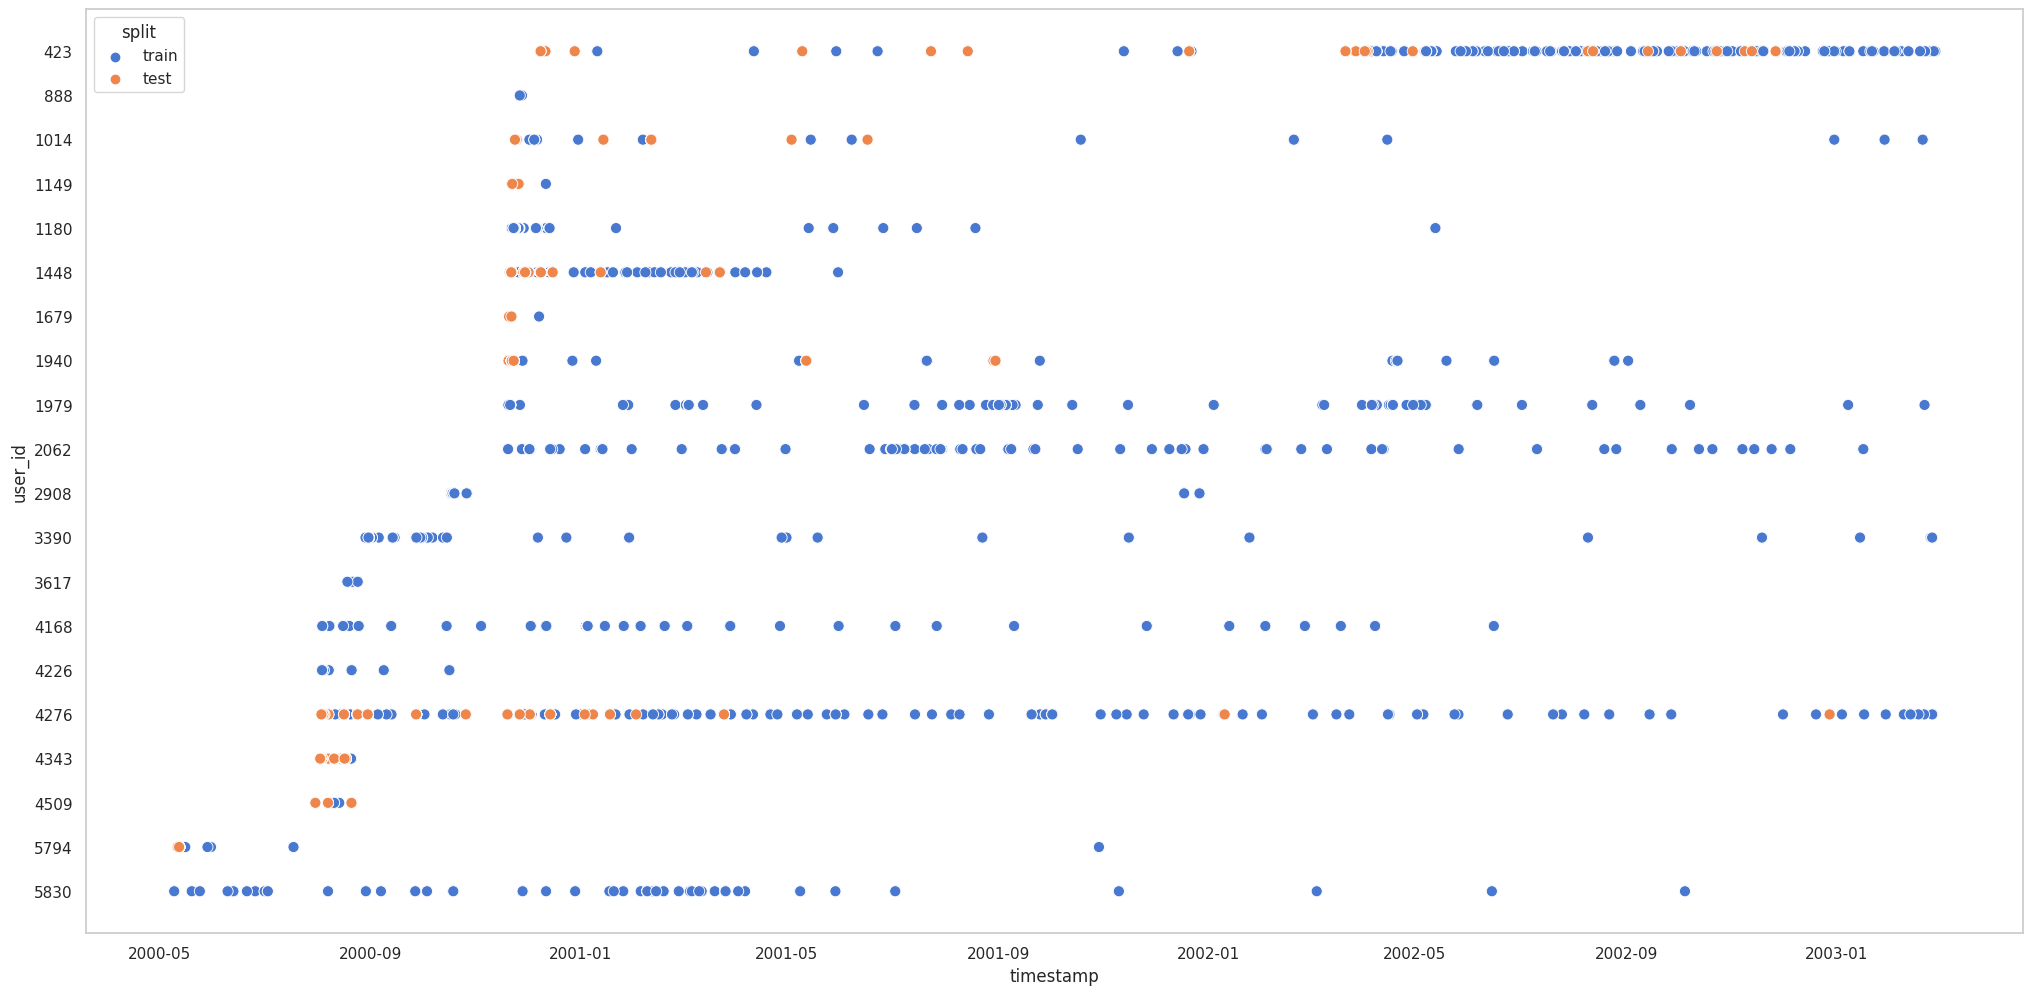

In [48]:
show_train_test(train, test)

In [49]:
get_df_info(train)

Total rows 27729, unique users: 20, unique items: 3326


In [50]:
get_df_info(test)

Total rows 500, unique users: 10, unique items: 449


You can use **float** as input for `item_test_size` or `user_test_size` parameters

In [51]:
from replay.splitters import TwoStageSplitter

user_splitter = TwoStageSplitter(
    first_divide_size=0.5,
    second_divide_size=0.015,
    shuffle=True,
    query_column="user_id",
    first_divide_column="user_id",
)

In [52]:
train, test = user_splitter.split(log_limit_20)

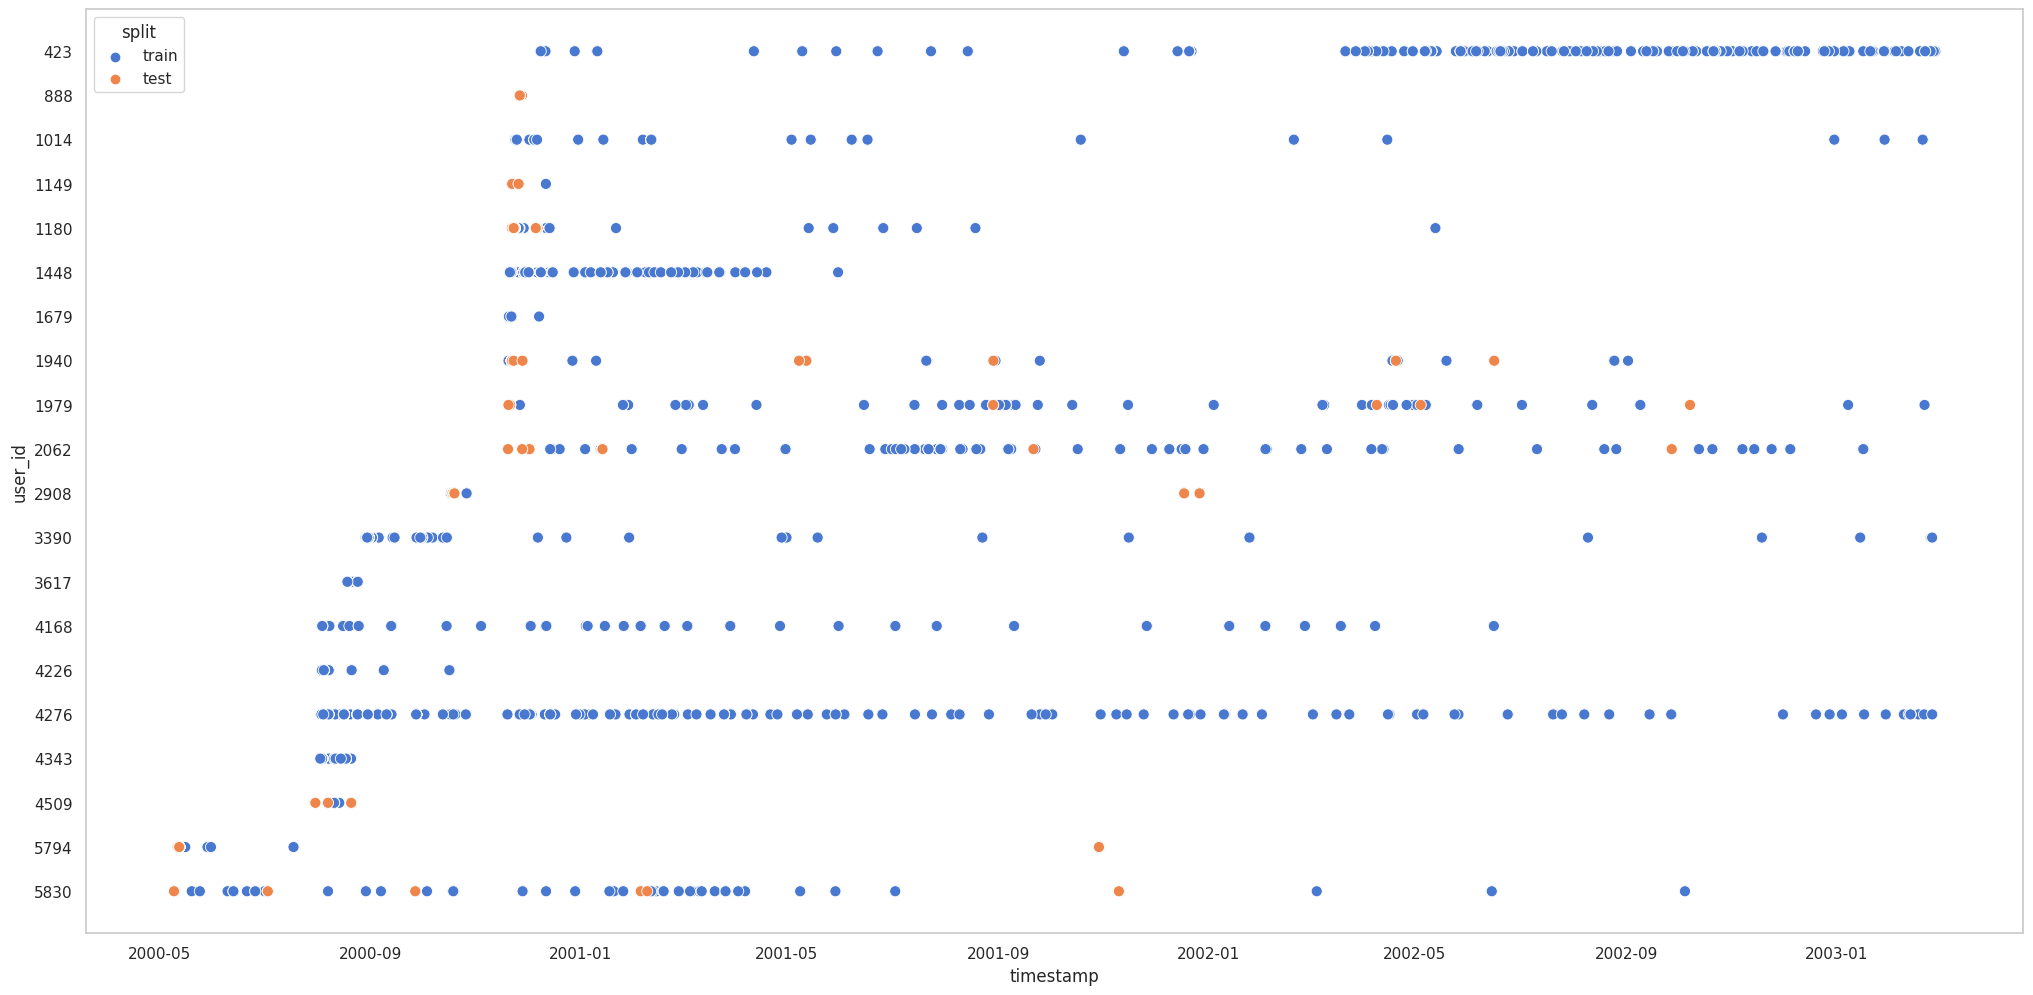

In [53]:
show_train_test(train, test)

In [54]:
get_df_info(train)

Total rows 28033, unique users: 20, unique items: 3326


In [55]:
get_df_info(test)

Total rows 196, unique users: 10, unique items: 192
